In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'train_2', label_mode='categorical', image_size=(224, 224), batch_size=8
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'valid_2', label_mode='categorical', image_size=(224, 224), batch_size=8
)


Found 42643 files belonging to 23 classes.
Found 5449 files belonging to 23 classes.


In [6]:
def build_densenet(num_classes=23):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze all layers

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.densenet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
model = build_densenet()
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
5331/5331 [==============================] - 356s 65ms/step - loss: 0.5384 - accuracy: 0.8351 - val_loss: 0.1949 - val_accuracy: 0.9356
Epoch 2/20
5331/5331 [==============================] - 336s 63ms/step - loss: 0.2882 - accuracy: 0.9034 - val_loss: 0.1567 - val_accuracy: 0.9499
Epoch 3/20
5331/5331 [==============================] - 336s 63ms/step - loss: 0.2677 - accuracy: 0.9093 - val_loss: 0.1383 - val_accuracy: 0.9527
Epoch 4/20
5331/5331 [==============================] - 339s 64ms/step - loss: 0.2604 - accuracy: 0.9124 - val_loss: 0.1346 - val_accuracy: 0.9569
Epoch 5/20
5331/5331 [==============================] - 343s 64ms/step - loss: 0.2471 - accuracy: 0.9171 - val_loss: 0.1413 - val_accuracy: 0.9550
Epoch 6/20
5331/5331 [==============================] - 338s 63ms/step - loss: 0.2455 - accuracy: 0.9178 - val_loss: 0.1327 - val_accuracy: 0.9589
Epoch 7/20
5331/5331 [==============================] - 337s 63ms/step - loss: 0.2456 - accuracy: 0.9178 - val_loss: 0

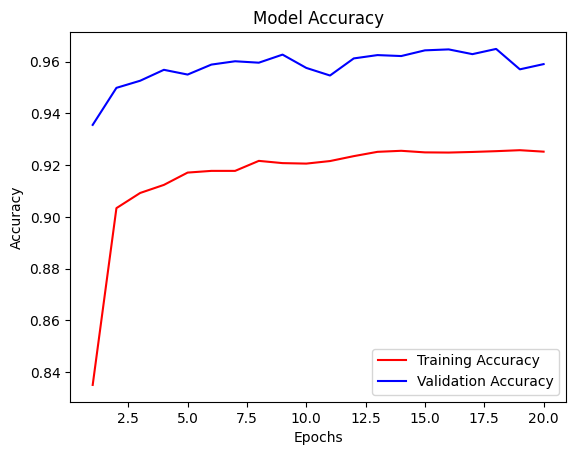

In [8]:
epochs = range(1, len(history.history['accuracy']) + 1)  

plt.title("Model Accuracy")
plt.plot(epochs, history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("DenseNet_modelaccuracy.jpg")
plt.legend()
plt.show()

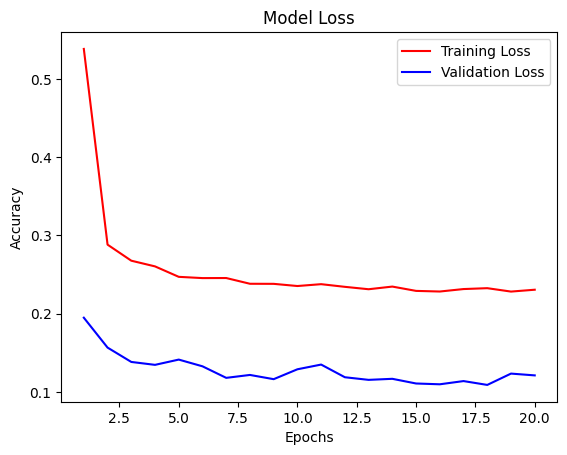

In [9]:
epochs = range(1, len(history.history['accuracy']) + 1)  # Get actual number of epochs

plt.title("Model Loss")
plt.plot(epochs, history.history['loss'], color='red', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("DenseNetloss.jpg")
plt.legend()
plt.show()

In [11]:
def fine_tune_model(model):
    # Find the base model in the model layers
    base_model = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):  # Check if the layer is a pre-trained model
            base_model = layer
            break

    if base_model is None:
        raise ValueError("Base model not found in the layers. Check model structure.")

    base_model.trainable = True  # Unfreeze all layers

    # Freeze BatchNorm layers
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    # Compile with a very low learning rate for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [17]:
model2 = fine_tune_model(model2)

In [12]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

In [14]:
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

Epoch 1/10
5331/5331 [==============================] - 337s 63ms/step - loss: 0.2288 - accuracy: 0.9255 - val_loss: 0.1316 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/10
5331/5331 [==============================] - 336s 63ms/step - loss: 0.2358 - accuracy: 0.9239 - val_loss: 0.1067 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 3/10
5331/5331 [==============================] - 337s 63ms/step - loss: 0.2244 - accuracy: 0.9271 - val_loss: 0.1403 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 4/10
5331/5331 [==============================] - 336s 63ms/step - loss: 0.2241 - accuracy: 0.9284 - val_loss: 0.1030 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 5/10
5331/5331 [==============================] - 334s 63ms/step - loss: 0.2247 - accuracy: 0.9293 - val_loss: 0.1004 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 6/10
5331/5331 [==============================] - 334s 63ms/step - loss: 0.2302 - accuracy: 0.9265 - val_loss: 0.1147 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 7/10
5331/5331 [==================

In [15]:
val_loss,val_accuracy=model.evaluate(val_ds)

682/682 [==============================] - 39s 56ms/step - loss: 0.0876 - accuracy: 0.9725


In [16]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    'Test_2',  
    label_mode='categorical',
    image_size=(224, 224),
    shuffle=False,
    batch_size=16
)


Found 5212 files belonging to 23 classes.


In [17]:
val_loss,val_accuracy=model.evaluate(test_ds)

326/326 [==============================] - 38s 115ms/step - loss: 0.0947 - accuracy: 0.9664


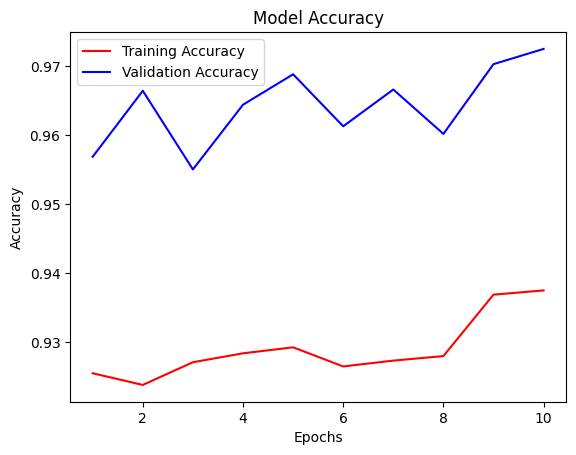

In [18]:
epochs = range(1, len(history_fine.history['accuracy']) + 1)  

plt.title("Model Accuracy")
plt.plot(epochs, history_fine.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, history_fine.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("Densenet_modelfine.jpg")
plt.legend()
plt.show()

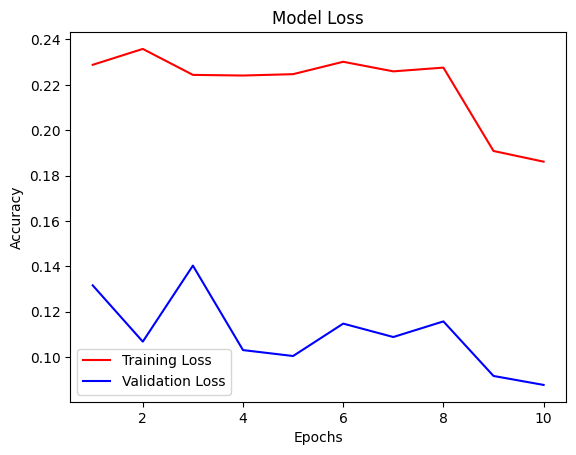

In [19]:
epochs = range(1, len(history_fine.history['accuracy']) + 1)  # Get actual number of epochs

plt.title("Model Loss")
plt.plot(epochs, history_fine.history['loss'], color='red', label='Training Loss')
plt.plot(epochs, history_fine.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("Densenet_model_lossfine.jpg")
plt.legend() 
plt.show()

In [20]:
y_pred=model.predict(test_ds)
y_pred,y_pred.shape

326/326 [==============================] - 38s 112ms/step


(array([[9.99999642e-01, 1.33289901e-09, 1.71865182e-07, ...,
         9.79566668e-15, 3.39009717e-16, 1.06764326e-12],
        [9.99898195e-01, 2.94015869e-08, 1.05045710e-05, ...,
         6.86099658e-12, 9.12451213e-13, 2.03728950e-10],
        [9.99989629e-01, 3.64506225e-09, 1.03838820e-05, ...,
         8.69353112e-16, 1.10424694e-16, 4.04110800e-13],
        ...,
        [1.52217058e-10, 8.52043062e-15, 2.21150509e-16, ...,
         1.27005025e-12, 5.17721199e-09, 9.96746898e-01],
        [1.47665713e-10, 3.14769433e-10, 2.16065162e-13, ...,
         9.60664366e-08, 9.35807210e-10, 9.99687433e-01],
        [1.08537568e-09, 3.23618288e-09, 2.66606073e-13, ...,
         2.79230335e-07, 1.95500533e-07, 9.99426723e-01]], dtype=float32),
 (5212, 23))

In [21]:
predicted_categories=tf.argmax(y_pred,axis=1)

In [22]:
true_categories=tf.concat([y for x,y in test_ds], axis=0)
true_categories

<tf.Tensor: shape=(5212, 23), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [23]:
y_true=tf.argmax(true_categories,axis=1)
y_true

<tf.Tensor: shape=(5212,), dtype=int64, numpy=array([ 0,  0,  0, ..., 22, 22, 22], dtype=int64)>

In [24]:
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import seaborn as sbn

In [25]:
cm= confusion_matrix(y_true,predicted_categories)
cm

array([[246,   1,   0,   5,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 244,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 220,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0, 249,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 210,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 219,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 185,   0,  15,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 232,   0,   0,   0,   0,   0,
   

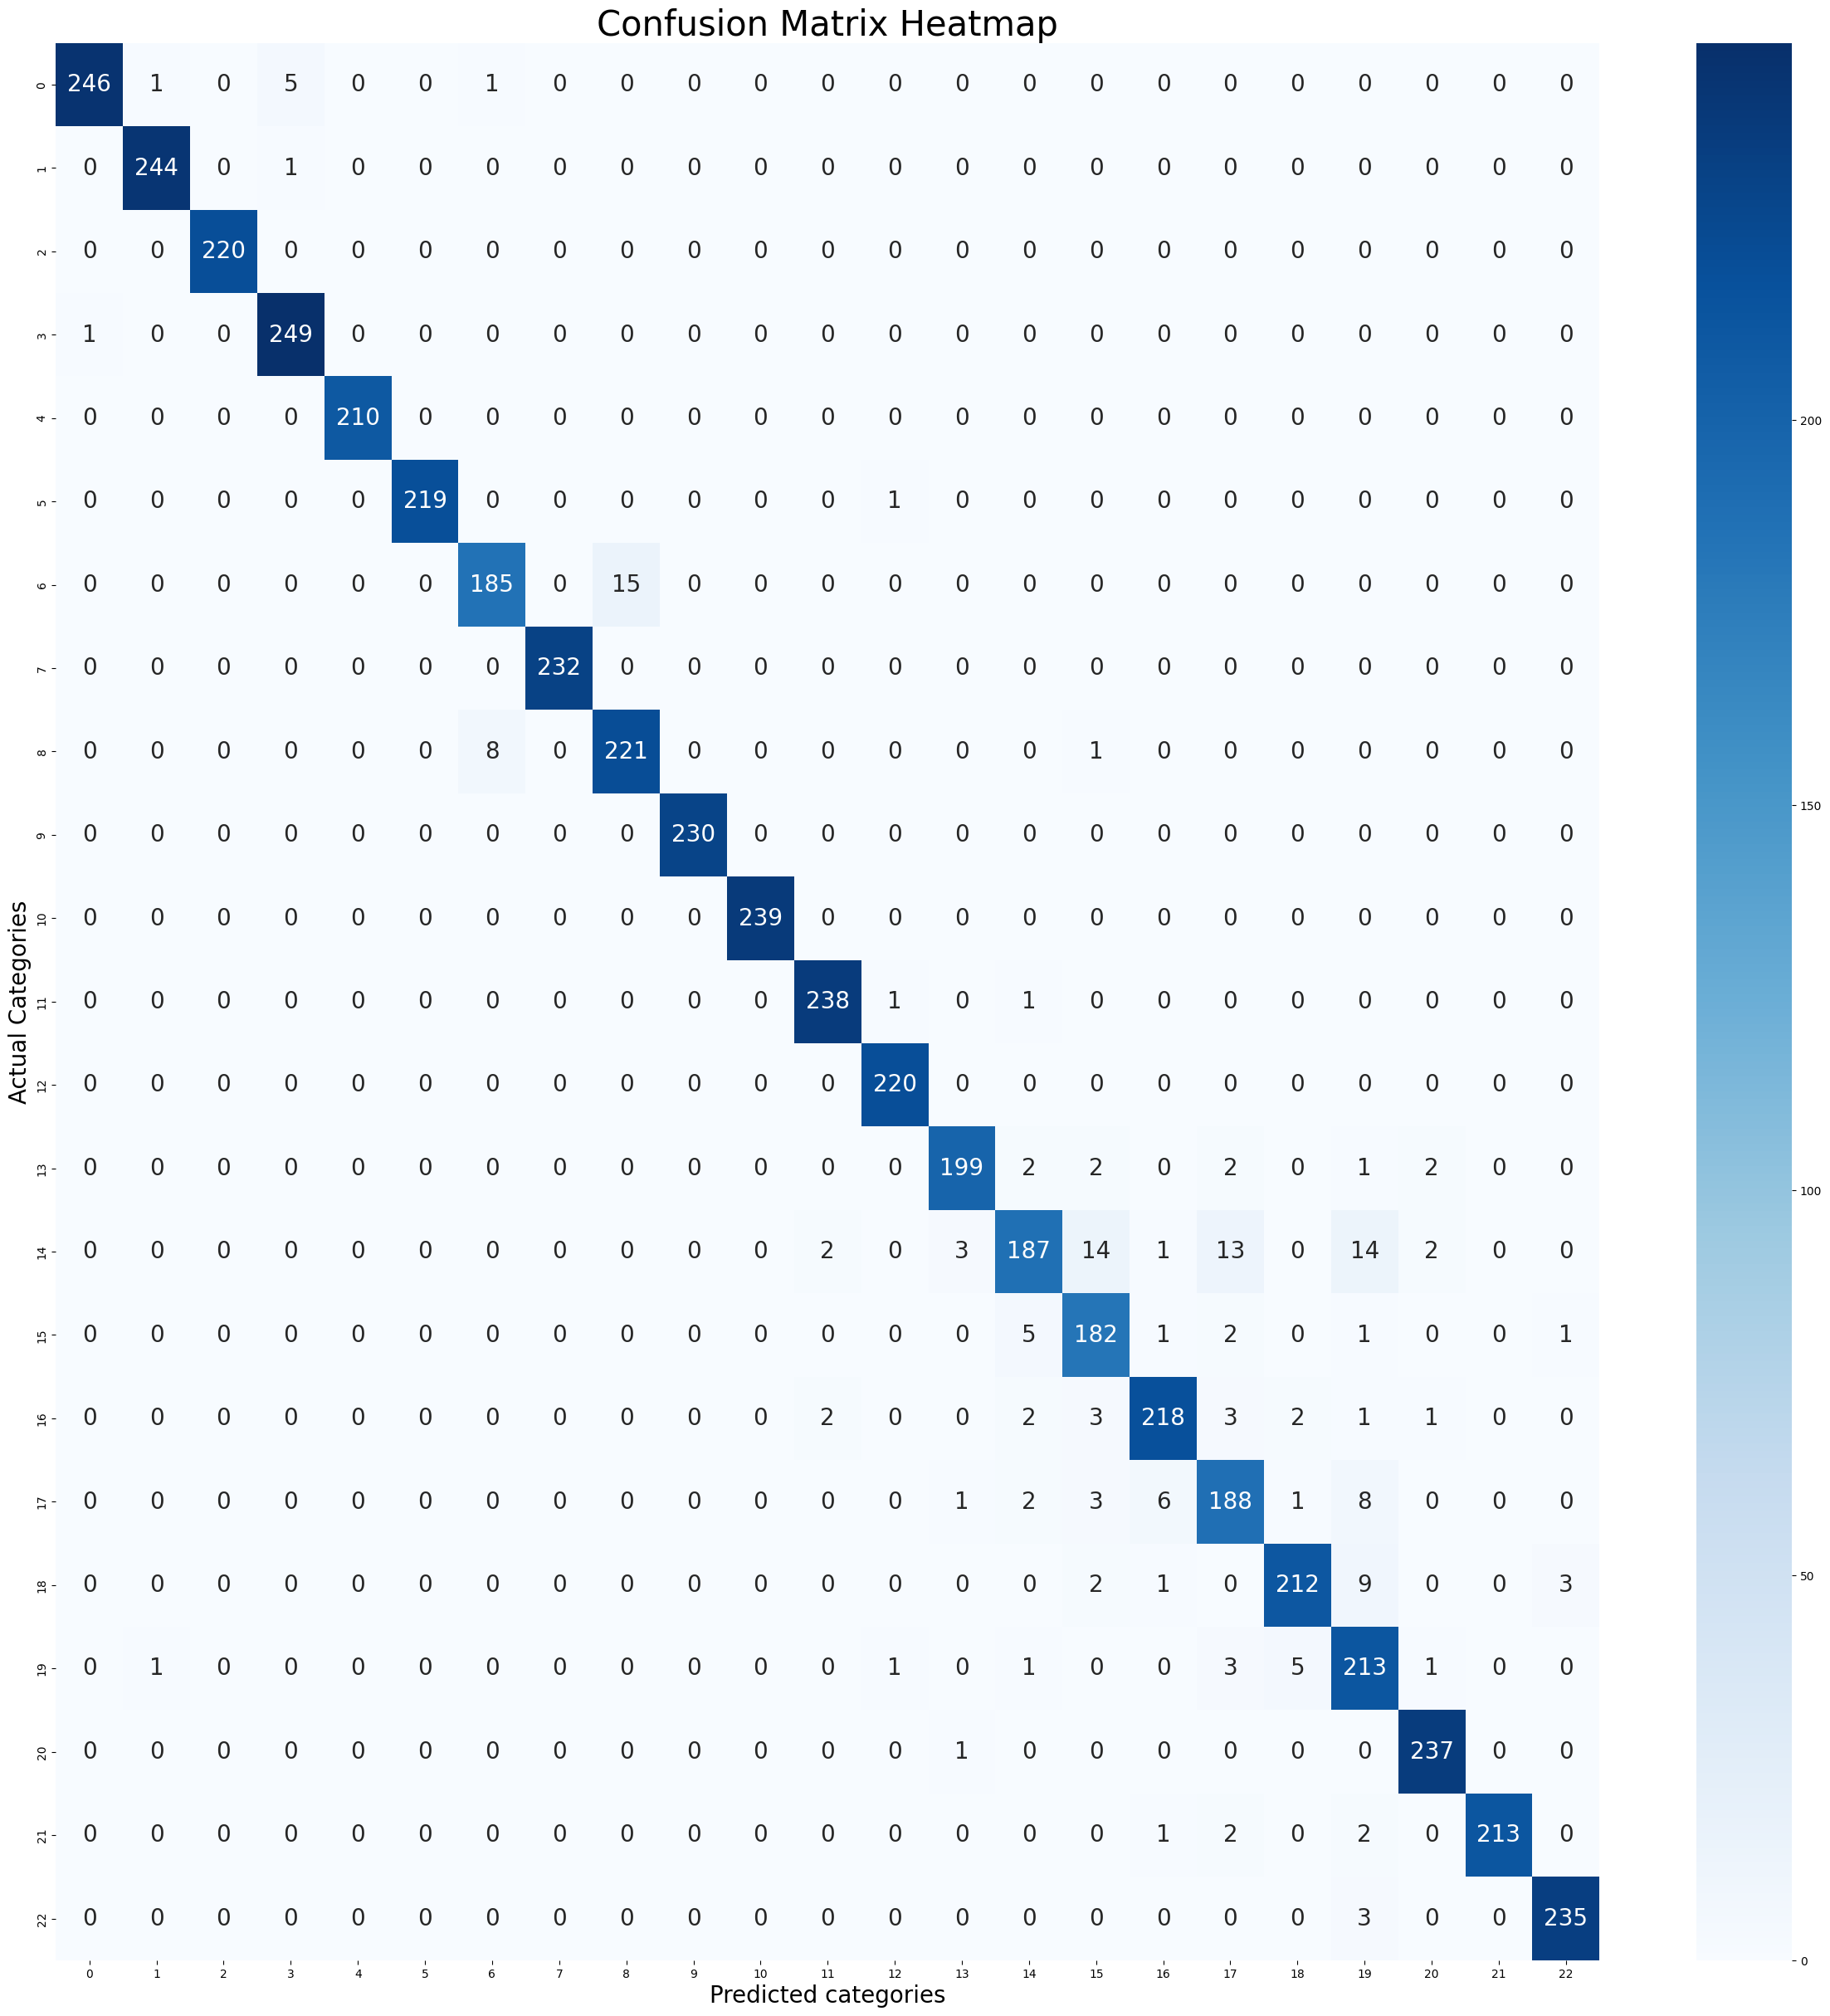

In [26]:
plt.figure(figsize=(30,30))
plt.title("Confusion Matrix Heatmap", fontsize=30)
sbn.heatmap(cm, annot=True, fmt="d", cmap="Blues",annot_kws={'size':20})
plt.xlabel("Predicted categories", fontsize=20)
plt.ylabel("Actual Categories", fontsize=20)
plt.savefig("Confusion_Densenet.jpg")
plt.show()

In [27]:
classes=[
    "Apple Scab",
    "Apple Black Rot",
    "Apple Cedar Apple Rust",
    "Apple Healthy",
    "Cherry (Including Sour) Powdery Mildew",
    "Cherry (Including Sour) Healthy",
    "Corn (Maize) Cercospora Leaf Spot/Grey Leaf",
    "Corn (Maize) Common Rust",
    "Corn (Maize) Northern Leaf Blight",
    "Corn (Maize) Healthy",
    "Potato Early Blight",
    "Potato Late Blight",
    "Potato Healthy",
    "Tomato Bacterial Spot",
    "Tomato Early Blight",
    "Tomato Late Blight",
    "Tomato Leaf Mold",
    "Tomato Septoria Leaf Spot",
    "Tomato Spider Mites/two spotted",
    "Tomato Target Spot",
    "Tomato Yellow Leaf Curl Virus",
    "Tomato Mosaic Virus",
    "Tomato Healthy"
]

In [28]:
class_report=classification_report(y_true,predicted_categories,target_names=classes)
print(class_report)

                                             precision    recall  f1-score   support

                                 Apple Scab       1.00      0.97      0.98       253
                            Apple Black Rot       0.99      1.00      0.99       245
                     Apple Cedar Apple Rust       1.00      1.00      1.00       220
                              Apple Healthy       0.98      1.00      0.99       250
     Cherry (Including Sour) Powdery Mildew       1.00      1.00      1.00       210
            Cherry (Including Sour) Healthy       1.00      1.00      1.00       220
Corn (Maize) Cercospora Leaf Spot/Grey Leaf       0.95      0.93      0.94       200
                   Corn (Maize) Common Rust       1.00      1.00      1.00       232
          Corn (Maize) Northern Leaf Blight       0.94      0.96      0.95       230
                       Corn (Maize) Healthy       1.00      1.00      1.00       230
                        Potato Early Blight       1.00      1.00

In [29]:
with open("precision_report_myDensenet2.txt","w") as file:
    file.write(class_report)

326/326 [==============================] - 36s 112ms/step


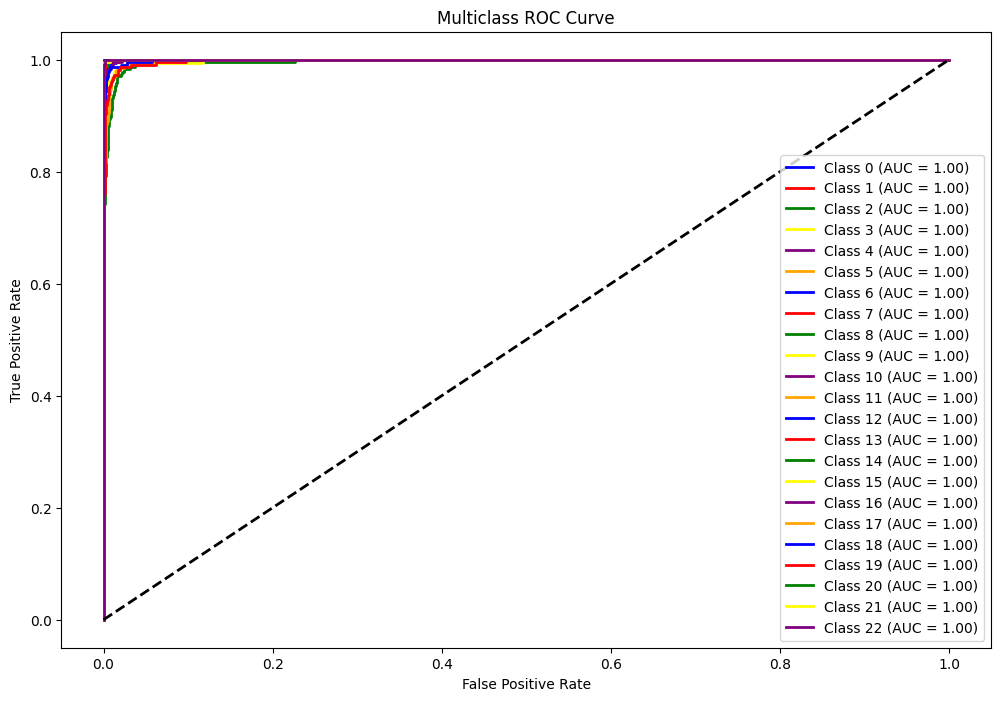

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Get number of classes
num_classes = test_ds.element_spec[1].shape[-1]

# Extract true labels
y_true_roc = np.concatenate([y.numpy() for x, y in test_ds], axis=0)  # Convert to NumPy
y_true_roc = np.argmax(y_true_roc, axis=1)  # Convert to class indices

# Get predicted probabilities
y_pred_prob_roc = model.predict(test_ds)  # Predicted probabilities

# Convert y_true to one-hot encoding
y_true_one_hot = label_binarize(y_true_roc, classes=np.arange(num_classes))

# Initialize as proper dictionaries
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_prob_roc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'orange'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.savefig("ROC Of Multiclass Of Densenet2.jpg")
plt.show()


In [34]:
model.save("Densnetfine.keras")